In [1]:
from keras.models import load_model

import glob
import cv2
import numpy as np

from tensorflow.keras.metrics import MeanIoU

import random
from matplotlib import pyplot as plt

2023-05-30 00:41:03.263662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 00:41:03.812722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#Load previously saved model
model = load_model("korropad_unet-model_sm_noEncoder_256_b8_e50_2000.hdf5", compile=False)

2023-05-30 00:42:08.185817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 00:42:08.207295: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading the test data

In [9]:
SIZE = 256
BASE_IMG_PATH = "../../data/Temperatur/1 h/1.4021/"
BASE_MASK_PATH = "../../data/Temperatur/1 h/1.4021/bin/"

img_paths = glob.glob(BASE_IMG_PATH + "*.tif") + glob.glob(BASE_IMG_PATH + "*.TIF")
img_paths.sort()
images = [cv2.imread(path, 0) for path in img_paths]
# resize images to fit the model
images_256 = [cv2.resize(image, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST) for image in images]
image_dataset = np.array(images_256)
image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset = image_dataset /255.

mask_paths = glob.glob(BASE_MASK_PATH + "*.jpg")
mask_paths.sort()
masks = [cv2.imread(path, 0) for path in mask_paths]
masks_256 = [cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST) for mask in masks]
mask_dataset = np.array(masks_256)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)
mask_dataset = mask_dataset /255.

In [10]:
#IOU
y_pred=model.predict(image_dataset)
y_pred_thresholded = y_pred > 0.5

2023-05-30 00:51:01.335634: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-05-30 00:51:01.369908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34611200 exceeds 10% of free system memory.


1/1 [==============================] - 1s 888ms/step


2023-05-30 00:51:01.641421: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2023-05-30 00:51:01.642411: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-05-30 00:51:01.666832: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


In [15]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, mask_dataset)
print(f"Mean IoU = {IOU_keras.result().numpy()} / 1.0")

Mean IoU = 0.8140769004821777 / 1.0


Get random image from test data set and compare prediction with actual mask

(1, 256, 256, 1)
1/1 [==============================] - 0s 86ms/step
(256, 256)


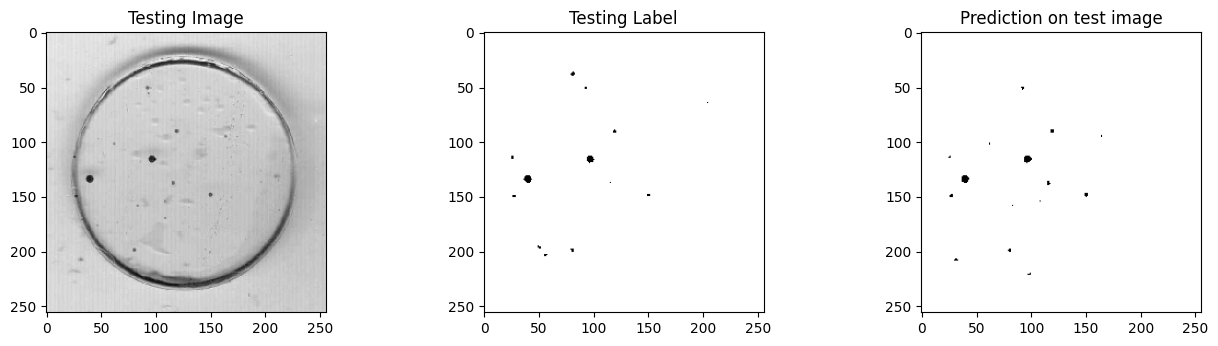

In [14]:
test_img_number = random.randint(0, len(image_dataset))
test_img = image_dataset[test_img_number]
ground_truth=mask_dataset[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction, cmap='gray')

plt.show()